In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(18641, 21)
(18641, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_RR_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RR_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict FL foot -> x

In [8]:
X_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.0753413 , -0.03407997,
       -0.01022839,  0.09069058,  0.22756822,  0.12994003, -0.38455901,
        0.25123128, -0.13026568, -0.38243401, -0.24825734,  0.12570569,
       -0.38843367, -0.27167571, -0.12398759, -0.38747641,  1.        ,
        0.        ])

In [9]:
Y_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.05453578, -0.00154245,  0.05637099, -0.00524158])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9904740224229541
RMSE:  0.02181801335971124
The lowest error is:  2.4996146547218157e-05
The highest error is:  0.07820594894214727
The avg. error is:  0.01633992080574641


In [12]:
model_rr_relative_swinging_x.coef_

array([[ 0.09558352,  0.62090045, -0.50914729, -0.13227248, -1.89426221,
         1.34743554,  0.11467514,  0.48284013, -0.67868982, -0.65857396]])

In [13]:
model_rr_relative_swinging_x.intercept_

array([0.48087558])

Text(0, 0.5, 'Predictions')

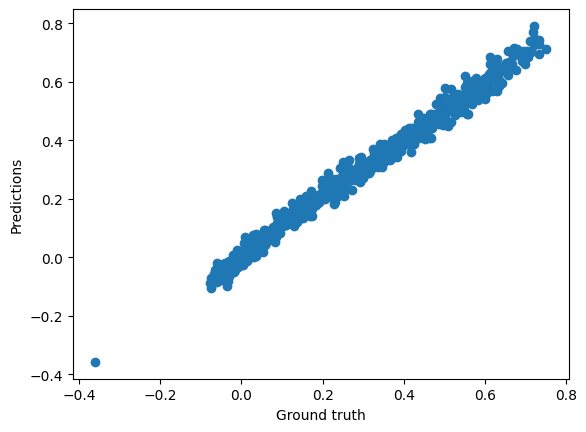

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RR foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9018871397088024
RMSE:  0.009448502605344047
The lowest error is:  1.0986932639579436e-05
The highest error is:  0.034111895551414036
The avg. error is:  0.007053500124685716


In [17]:
model_rr_relative_swinging_y.coef_

array([[-0.00811884,  0.12795483,  0.29975576, -1.71326575, -0.06978923,
         0.63645976, -0.57856001,  0.31339186, -0.31169629, -0.3608843 ]])

In [18]:
model_rr_relative_swinging_y.intercept_

array([-0.06971812])

Text(0, 0.5, 'Predictions')

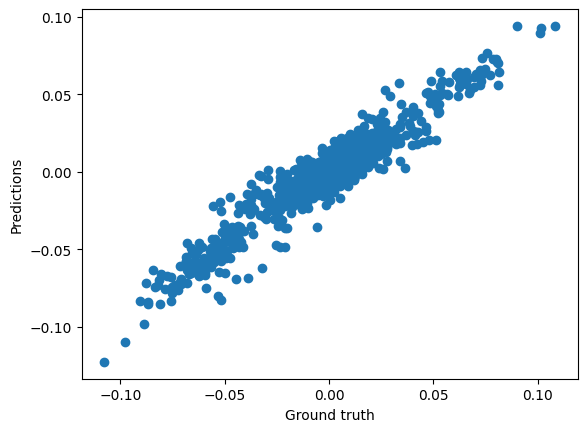

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')